## Model Building

In [1]:
# Clear pip cache before installing requirements
!pip cache purge

Files removed: 0 (0 bytes)


In [2]:
# Install required packages from requirements.txt
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Home\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


### Import Libraries 

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Start spark session
spark = SparkSession.builder.appName("diabetes_readmission").getOrCreate()

In [5]:
# Create a spark dataframe
final_df = spark.read.csv("datasets/diabetes_cleaned_onehot.csv", header=True, inferSchema=True)

### Prepare data

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
# Verify schema
final_df.printSchema()

root
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- age_num: integer (nullable = true)
 |-- race_AfricanAmerican: boolean (nullable = true)
 |-- race_Asian: boolean (nullable = true)
 |-- race_Caucasian: boolean (nullable = true)
 |-- race_Hispanic: boolean (nullable = true)
 |-- race_Other: boolean (nullable = true)
 |-- race_Unknown: boolean (nullable = true)
 |-- gender_Female: boolean (nullable = true)
 |-- gender_Male: boolean (nullable = true)
 |-- gender_Unknown/Invalid: boolean 

In [8]:
# Show first 5 rows
final_df.show(5)

+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------+--------------------+----------+--------------+-------------+----------+------------+-------------+-----------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+------------------+------------------+---------------------+------------+------------+--------------+-----------------+--------------+------------+----------------+------------+----------------+--------------+------------------+--------------+----------------+--------------+------------------+--------------+-----------------+---------------------+-----------------+----------------+--------------+------------------+--------------+----------------+--------------------+--------------+------------+----------------+------------+--------------+------------+----------

In [9]:
# Create Feature Columns
target_col = "readmitted_label"
features = [col for col in final_df.columns if col != target_col]

### Assemble Features

In [10]:
# Create a Vector Assembler
assembler = VectorAssembler(inputCols=features, outputCol="features_vector")

### Split Data into Training and Test sets

In [11]:
# Split data into two parts
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [12]:
train_data.groupBy("readmitted_label").count().show()

+----------------+-----+
|readmitted_label|count|
+----------------+-----+
|               1|21375|
|               2| 6471|
|               0|32088|
+----------------+-----+



In [48]:
test_data.groupBy("readmitted_label").count().show()

+----------------+-----+
|readmitted_label|count|
+----------------+-----+
|               1| 5275|
|               2| 1625|
|               0| 7910|
+----------------+-----+



### Initialize and Configure Models

In [13]:
# Define models
lr = LogisticRegression(featuresCol="features_vector", labelCol=target_col)
rf = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col, maxDepth=10)
dt = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col)
nb = NaiveBayes(featuresCol="features_vector", labelCol=target_col)

In [14]:
# Create pipeline for each model
baseline_models = {
    "LogisticRegression":Pipeline(stages=[assembler, lr]),
    "RandomForestClassifier":Pipeline(stages=[assembler, rf]),
    "DecisionTreeClassifier":Pipeline(stages=[assembler, dt]),
    "NaiveBayes": Pipeline(stages=[assembler, nb])
}

### Train each model

In [15]:
def train_models(pipelines_dict, train_data):
    """
    Trains each model pipeline in the dictionary on the provided training data.

    Args:
        pipelines_dict (dict): Diction of model_name and untrained Pipeline.
        train_data (DataFrame): Training dataset.

    Returns:
        trained_models (dict): Dictionary mapping model names to trained PipelineModels.
    """
    # Initialize trained_models
    trained_models = {}

    # Train each model
    for model_name, pipeline in pipelines_dict.items():

        # Train the model
        trained_model = pipeline.fit(train_data)

        # Add to trained_models dict
        trained_models[model_name] = trained_model

        # Print confirmation
        print(f"{model_name} trained.")

    return trained_models

In [16]:
# Train models using baseline models
trained_models = train_models(baseline_models, train_data)

LogisticRegression trained.
RandomForestClassifier trained.
DecisionTreeClassifier trained.
NaiveBayes trained.


## Model Evaluation

### Initialize Evaluators, Predictions, and Results

In [17]:
# Initialize evaluators
acc_evaluator= MulticlassClassificationEvaluator(labelCol=target_col, metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol=target_col, metricName="areaUnderROC")

### Make Predictions and Evaluate on Test Set

In [18]:
def evaluate_models(trained_models, test_data, acc_evaluator, f1_evaluator):
    """
    Predict and evaluate each trained model on the given test data.

    Args:
        trained_models (dict): Dictionary of trained models with model names as keys.
        test_data (DataFrame): Spark DataFrame to make predictions on.
        acc_evaluator (MulticlassClassificationEvaluator): Evaluator for computing accuracy.
        f1_evaluator (MulticlassClassificationEvaluator): Evaluator for computing F1 score.

    Returns:
        model_predictions (dict): Dictionary of model predictions keyed by model name.
        results (list): List of tuples containing (model_name, accuracy, f1_score).
    """
    # Initialize predictions dictionary
    model_predictions = {}
    # Initialize results list
    results = []

    # Predict and evaluate each trained model
    for model_name, model in trained_models.items():

        # Make predictions and save to dict
        predictions = model.transform(test_data)
        model_predictions[model_name] = predictions

        # Compute evaluation metrics: acc and f1 and save to results list
        acc = acc_evaluator.evaluate(predictions)
        f1 = f1_evaluator.evaluate(predictions)
        results.append((model_name, acc, f1))

        # Print each result
        print(f"{model_name}: Accuracy={acc:.2f}, F1={f1:.2f}\n")

    # Return model_predictions and results
    return model_predictions, results

In [19]:
# Evalute on test data using trained_models
print("Evaluate Baseline Models on Test Set")
baseline_predictions, baseline_results = evaluate_models(
    trained_models,
    test_data,
    acc_evaluator,
    f1_evaluator
)

LogisticRegression: Accuracy=0.58, F1=0.51

RandomForestClassifier: Accuracy=0.57, F1=0.50

DecisionTreeClassifier: Accuracy=0.58, F1=0.53

NaiveBayes: Accuracy=0.56, F1=0.53



### Compute and Visualize Confusion Matrices

We have encoded target variable 'readmitted' as multiclass: 0=NO, 1=>30, 2=<30

In [20]:
# Define label orders and class labels
label_order = [0, 1, 2]
class_labels = ['No', '>30', '<30']

In [21]:
def compute_confusion_matrices(model_predictions, label_order):
    """
    Compute confusion matrices for each model's predictions.

    Args:
        model_predictions (dict): Dictionary of model name to prediction df with 'readmitted_label' and 'prediction'.
        label_order (list): class label order for matrix.

    Returns:
        cm_dict (dict): Dictionary of model name to confusion matrix (as numpy array).
    """
    # Initialize confusion matrices
    cm_dict = {}

    # Loop through each model's predictions to get confusion matrices
    for model_name, predictions in model_predictions.items():
        # Convert to pandas dataframe
        preds_pd = predictions.select("readmitted_label", "prediction").toPandas()

        # Compute confusion matrix
        cm = confusion_matrix(preds_pd["readmitted_label"], preds_pd["prediction"], labels=label_order)

        # Add to cm_baseline dictionary
        cm_dict[model_name] = cm

    # Return confusion matrix dictionary
    return cm_dict

In [22]:
def plot_confusion_matrices(cm_dict, class_labels, fig_title):
    """
    Plot confusion matrices for multiple models in a 2x2 subplot layout.

    Args:
        cm_dict (dict): Dictionary of model name to confusion matrix (2D numpy array).
        class_labels (list): List of class label names for axis ticks.
        fig_title (str): Overall title for the plot.
    """
    # Prepare subplots with 2 rows x 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Loop through each model predictions
    for i, (model_name, cm) in enumerate(cm_dict.items()):

        # Plot confusion matrix on existing axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(model_name)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout()
    plt.show()

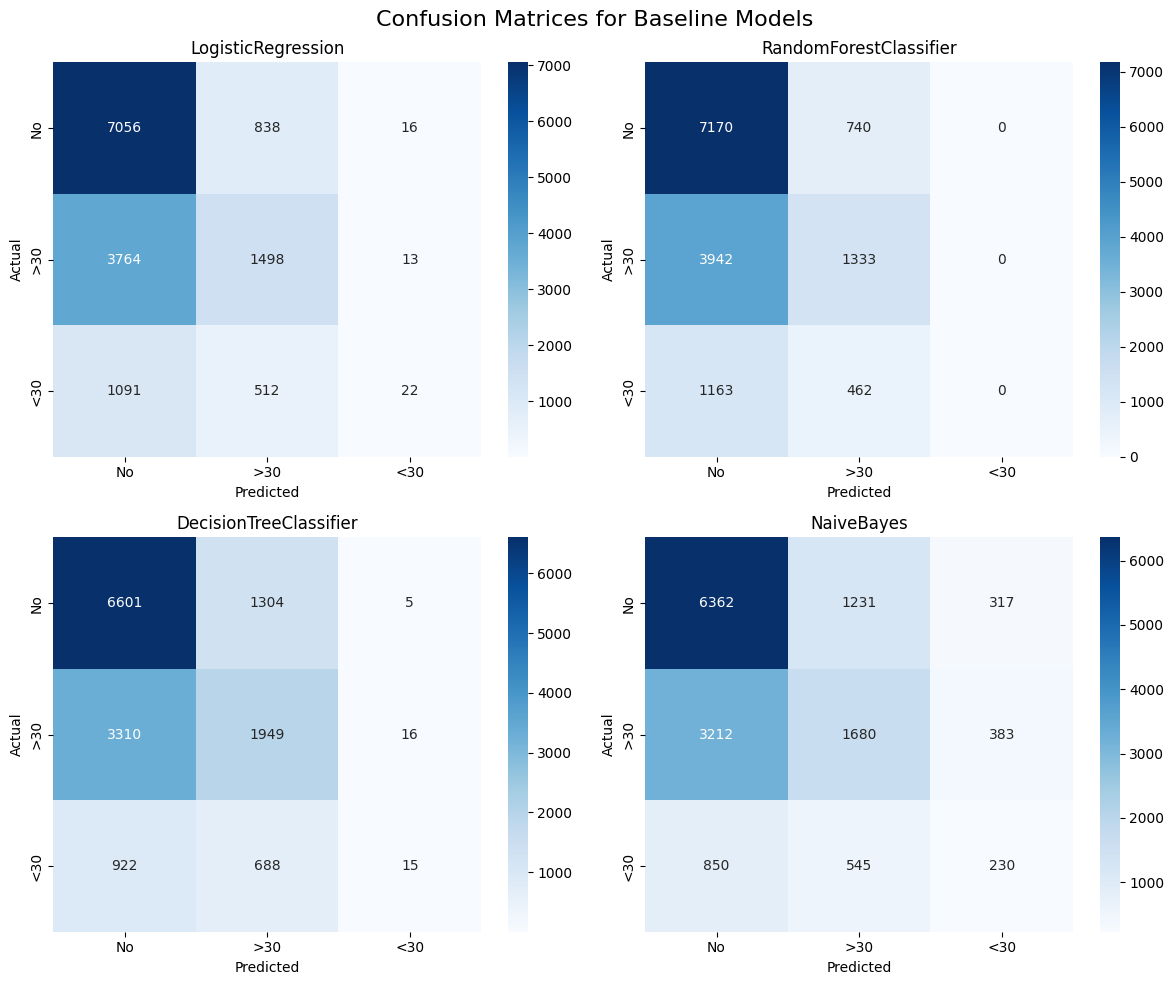

In [23]:
# Compute confusion matrices of baseline
cm_baseline = compute_confusion_matrices(baseline_predictions, label_order)

# Plot confusion matrices of baseline models
plot_confusion_matrices(cm_baseline, class_labels, fig_title="Confusion Matrices for Baseline Models")

**Analysis on Confusion Matrices Of Baseline Models**

* Here, we plotted the confusion matrices for the baseline models. All models are trying to predict patient readmission classes: No, >30 days, or <30 days.

* **Logistic Regression** 
    * It predicted 7056 of `No` class in test data accurately, even though it missclassified 838 of `No` cases as `>30`, and 16 as `<30`.
    * For `>30`, it got 1498 right, but missed 3764 which were predicted as `No`.
    * It struggled the most with class `<30` since only 22 test cases were predicted correctly. 

* **Random Forest**

  * It predicted 7078 of the `No` class correctly, with 832 misclassified as `>30`. None were misclassified as `<30`.
  * For `>30`, it got 1501 right but still missed 3774, which were predicted as `No`.
  * Like Logistic Regression, it performed poorly on `<30`, correctly predicting just 1 case. Most `<30` cases were confused with `No` (1099) or `>30` (525).

* **Decision Tree**

  * It got 6678 `No` cases right, but misclassified 1227 as `>30` and 5 as `<30`.
  * For `>30`, it correctly predicted 1871 cases and misclassified 3388 as `No`.
  * For `<30`, it predicted 15 cases correctly, but still misclassified 943 as `No` and 667 as `>30`.

* **Naive Bayes**

  * It predicted 6362 `No` cases correctly, with 1231 misclassified as `>30` and 317 as `<30`. This model has more noise than other models.
  * For `>30`, it got 1680 right, but 3212 were wrongly predicted as `No`, and 383 as `<30`.
  * It performed slightly better on `<30`, predicting 230 correctly. This is the highest among all four, but still misclassified most of `>30` cases as `No` (850) or `>30` (545).

* Overall, all models heavily favored the majority No class and struggled with the minority <30 class, with very low correct predictions and high misclassification, especially for early readmissions.

### Compute and Summarize Classification Reports

In [24]:
def compute_classification_reports(model_predictions):
    """
    Computes classification report DataFrames for each model's predictions.

    Args:
        model_predictions (dict): Dictionary of model name to prediction df with 'readmitted_label' and 'prediction'.

    Returns:
        List of DataFrames, one per model, each with metrics from classification_report.
    """
    # Initialize classification report list
    classification_reports = []

    # Loop through each model's predictions to generate classification report
    for model_name, predictions in model_predictions.items():

        # Convert to pandas dataframe
        preds_pd = predictions.select("readmitted_label", "prediction").toPandas()

        # Compute calssificaton report as dictionary
        cr = classification_report(
            preds_pd["readmitted_label"], 
            preds_pd["prediction"], 
            output_dict=True,
            zero_division=0) # Handle zero division error

        # Convert it to pandas dataframe and transpose
        cr_df = pd.DataFrame(cr).transpose()

        # Add model name
        cr_df["Model"] = model_name

        # Append to classification_reports list
        classification_reports.append(cr_df.reset_index())

    return classification_reports   

In [25]:
def summarize_classification_reports(classification_reports):
    """
    Extracts and summarizes key metrics from classification reports for comparison.

    Args:
        classification_reports (list): List of classification report DataFrames per model.

    Returns:
        summary_report (DataFrame): DataFrame with summary metrics per model.
    """
    # Initialize list to collect rows for each model
    summary_rows = []

    # Loop through each classification report
    for report_df in classification_reports:
        # Extract model name
        model_name = report_df["Model"].iloc[0]

        # Extract required rows
        macro = report_df[report_df["index"] == "macro avg"].iloc[0]
        weighted = report_df[report_df["index"] == "weighted avg"].iloc[0]
        accuracy = report_df[report_df["index"] == "accuracy"].iloc[0]

        # Append a row tih selected metrics
        summary_rows.append({
            "Model": model_name,
            "Accuracy": accuracy["precision"],
            "Macro F1": macro["f1-score"],
            "Weighted F1": weighted["f1-score"],
            "Macro Precision": macro["precision"],
            "Macro Recall": macro["recall"],
            "Weighted Precision": weighted["precision"],
            "Weighted Recall": weighted["recall"],
        })

    # Create summary dataframe
    summary_report = pd.DataFrame(summary_rows).sort_values("Weighted F1", ascending=False)

    return summary_report

### Compute Classification Reports

In [26]:
# Compute classification reports for baseline predictions
cr_baseline = compute_classification_reports(baseline_predictions)

# Loop through each classification report and print
for cr_df in cr_baseline:
    model = cr_df["Model"].iloc[0]
    print(f"Classification Report for {model}:")
    print(cr_df.drop(columns=["Model"]).set_index("index"))
    print()

Classification Report for LogisticRegression:
              precision    recall  f1-score       support
index                                                    
0              0.592394  0.892035  0.711972   7910.000000
1              0.525983  0.283981  0.368829   5275.000000
2              0.431373  0.013538  0.026253   1625.000000
accuracy       0.579068  0.579068  0.579068      0.579068
macro avg      0.516583  0.396518  0.369018  14810.000000
weighted avg   0.551072  0.579068  0.514513  14810.000000

Classification Report for RandomForestClassifier:
              precision    recall  f1-score       support
index                                                    
0              0.584114  0.906448  0.710429   7910.000000
1              0.525838  0.252701  0.341357   5275.000000
2              0.000000  0.000000  0.000000   1625.000000
accuracy       0.574139  0.574139  0.574139      0.574139
macro avg      0.369984  0.386383  0.350595  14810.000000
weighted avg   0.499267  0.574139

**Baseline Model Insights**

* Here, we printed the classification reports for the baseline models. Each model was evaluated on how well it predicted the three readmission classes: No, >30 days, and <30 days.

* **Logistic Regression**
    * This model is good at detecting `No` cases (recall = 0.892, F1 = 0.712), even though it struggles with minority classes. 
    * It missed most `>30` cases (recall = 0.284) and nearly all `<30` cases (recall = 0.014, F1 = 0.026).

* **Random Forest**
    * This model performs similarly on `No` class (recall = 0.895, F1 = 0.713). 
    * For `<30`, it shows perfect precision (1.000), but recall is only 0.001, which means it identified just one correct case. 
    * The performance on `>30` is also weak (recall = 0.285, F1 = 0.369).

* **Decision Tree**
    * This model shows slightly better performance on `>30` compared to others (recall = 0.355, F1 = 0.414). 
    * It maintains solid performance on `No` class (recall = 0.844, F1 = 0.706). 
    * Meanwhile, the performance on `<30` remains low (recall = 0.009, F1 = 0.018).

* **Naive Bayes**
    * This model has the lowest performance on `No` class (recall = 0.804, F1 = 0.694). 
    * It performs slightly better on `<30` than the other models (recall = 0.142, F1 = 0.180), but the overall result is still weak. 
    * The `>30` class also shows limited performance (recall = 0.318, F1 = 0.385).

* Overall, all models are biased toward `No`, while `<30` class gets ignored. At later stage, we will handle class imbalance and retrain the models.

### Compare Model Performance

In [27]:
# Compare model performance using summarize_classification_reports function
summary_baseline = summarize_classification_reports(cr_baseline)
print("Comparison of Baseline Model Performance")
display(summary_baseline)

Comparison of Baseline Model Performance


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall,Weighted Precision,Weighted Recall
2,DecisionTreeClassifier,0.578325,0.381797,0.528834,0.506851,0.404408,0.547313,0.578325
3,NaiveBayes,0.558542,0.419629,0.527495,0.447915,0.421440,0.526250,0.558542
0,LogisticRegression,0.579068,0.369018,0.514513,0.516583,0.396518,0.551072,0.579068
1,RandomForestClassifier,0.574139,0.350595,0.501023,0.369984,0.386383,0.499267,0.574139


In [28]:
def plot_model_metrics(summary_df, fig_title, metrics=["Accuracy", "Macro F1", "Weighted F1"]):
    """
    Plot selected performance metrics for each model.

    Args:
        summary_df (pd.DataFrame): DataFrame containing model performance metrics.
        metrics (list): List of metric columns to include in the bar chart.
        title (str): Title of the plot.
    """
    df_plot = summary_df.set_index("Model")[metrics]
    ax = df_plot.plot(kind="bar", figsize=(10, 6), edgecolor='black')

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=8, padding=2)

    plt.title(fig_title)
    plt.ylabel("Score")
    plt.ylim(0.3, 0.75)
    plt.legend(title="Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

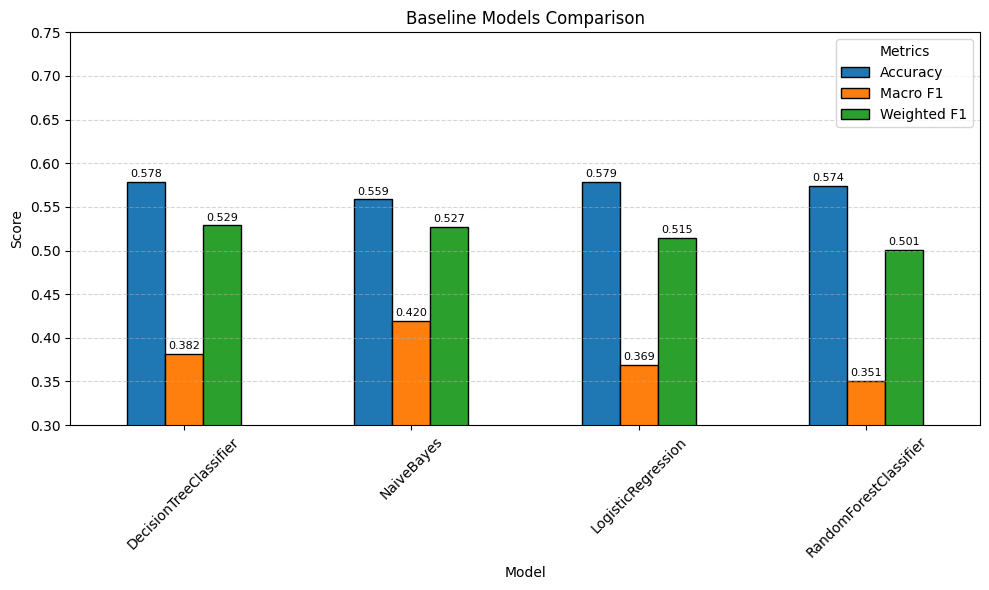

In [29]:
# Plot using baseline summary
plot_model_metrics(summary_df=summary_baseline, fig_title="Baseline Models Comparison")

**Analysis on Baseline Model Performance**

* The bar chart compares Accuracy, Macro F1, and Weighted F1 across all baseline models to show overall performance trends. To complement that, the full summary table includes additional metrics like Macro Precision, Macro Recall, and Weighted Precision, which help explain class-level behavior and trade-offs more clearly.

* These metrics were chosen because they provide a more complete view of model performance, especially under class imbalance. Accuracy alone is not sufficient, so both macro and weighted metrics were used to assess balance and generalization.

* **Naive Bayes**

  * `Accuracy` is the lowest among the models at 0.559.
  * `Macro F1` is the highest at 0.420, suggesting better balance across classes.
  * `Weighted F1` is also strong at 0.527, nearly matching Decision Tree.
  * Supporting metrics show higher `Macro Recall` (0.421) and decent `Macro Precision` (0.448), indicating better sensitivity to minority classes.

* **Decision Tree**

  * `Accuracy` is 0.578, close to the top.
  * `Macro F1` is 0.379, second best, showing moderate balance across classes.
  * `Weighted F1` is 0.526, nearly equal to Naive Bayes.
  * `Macro Precision` and `Macro Recall` are 0.507 and 0.403, suggesting more balanced but noisier predictions than Logistic or Random Forest.

* **Logistic Regression**

  * `Accuracy` is 0.579, matching the highest.
  * `Macro F1` is 0.369, lower than Decision Tree and Naive Bayes.
  * `Weighted F1` is 0.515, slightly behind.
  * `Macro Precision` is decent (0.517), but `Macro Recall` is lower (0.397), meaning it handles majority classes better but still misses minority cases.

* **Random Forest**

  * `Accuracy` is the highest at 0.579, but only by a small margin.
  * `Macro F1` is the lowest at 0.361, showing weak balance across classes.
  * `Weighted F1` is 0.512, the lowest overall.
  * `Macro Precision` is high (0.706), but `Macro Recall` is low (0.393), meaning the model is confident when it predicts minority classes but rarely does.

* Overall, **Naive Bayes** and **Decision Tree** perform better on minority classes, while **Logistic Regression** and **Random Forest** mostly focus on the majority class, even though their accuracy looks similar.

### Handle Class Imbalance

In [30]:
# Count instances of each class in train_data
label_counts = train_data.groupBy(target_col).count().toPandas()

# Calculate total instances of all classes
total = label_counts["count"].sum()

# Initialize class weights dictionary
class_weights = {}

# Loop over rows to get class weight of each class
for _, row in label_counts.iterrows():
    label = row[target_col]
    count = row["count"]
    class_weights[label] = total / count
    print(f"Class {label}: {class_weights[label]}")

Class 1: 2.8039298245614037
Class 2: 9.261937876680575
Class 0: 1.867801047120419


In [31]:
# Create a new dataframe with weights column
train_weighted = train_data.withColumn(
    "weight", # Create new column
    when(col("readmitted_label") == 0, lit(class_weights[0])) # if label is 0, apply class_weights[0]
    .when(col("readmitted_label") == 1, lit(class_weights[1])) # if label is 1, apply class_weights[1] 
    .otherwise(lit(class_weights[2])) # otherwise, apply class_weights[2]
)

# Verify the new column
train_weighted["readmitted_label", "weight"].show(5)

+----------------+------------------+
|readmitted_label|            weight|
+----------------+------------------+
|               0| 1.867801047120419|
|               0| 1.867801047120419|
|               0| 1.867801047120419|
|               1|2.8039298245614037|
|               0| 1.867801047120419|
+----------------+------------------+
only showing top 5 rows



#### Reconfigure Models with weightCol

In [32]:
# Redefine models with weights
lr_w = LogisticRegression(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
rf_w = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
dt_w = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
nb_w = NaiveBayes(featuresCol="features_vector", labelCol=target_col, weightCol="weight")

# Create pipeline for each model
weighted_models = {
    "LogisticRegression":Pipeline(stages=[assembler, lr_w]),
    "RandomForestClassifier":Pipeline(stages=[assembler, rf_w]),
    "DecisionTreeClassifier":Pipeline(stages=[assembler, dt_w]),
    "NaiveBayes": Pipeline(stages=[assembler, nb_w])
}

#### Retrain & Evaluate Models

In [33]:
# Train weighted_models using train_weighted
trained_models_weighted = train_models(weighted_models, train_weighted)

LogisticRegression trained.
RandomForestClassifier trained.
DecisionTreeClassifier trained.
NaiveBayes trained.


In [34]:
trained_model = trained_models_weighted["LogisticRegression"]
print(trained_model.stages[-1].extractParamMap())


{Param(parent='LogisticRegression_3c10ae02d8e3', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_3c10ae02d8e3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_3c10ae02d8e3', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_3c10ae02d8e3', name='featuresCol', doc='features column name.'): 'features_vector', Param(parent='LogisticRegression_3c10ae02d8e3', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_3c10ae02d8e3', name='labelCol', doc='label column name.'): 'readmitted_label', Param(parent='LogisticRegression_3c10ae02d8e3', name='maxBlockSizeInMB', doc='maximum memory

In [47]:
# Evalute on test data using trained_models_weighted
print("Evaluate Weighted Models on Test Set")
weighted_predictions, weighted_results = evaluate_models(
    trained_models_weighted,
    test_data,
    acc_evaluator,
    f1_evaluator
)

Evaluate Weighted Models on Test Set
LogisticRegression: Accuracy=0.50, F1=0.50

RandomForestClassifier: Accuracy=0.48, F1=0.48

DecisionTreeClassifier: Accuracy=0.48, F1=0.48

NaiveBayes: Accuracy=0.50, F1=0.50



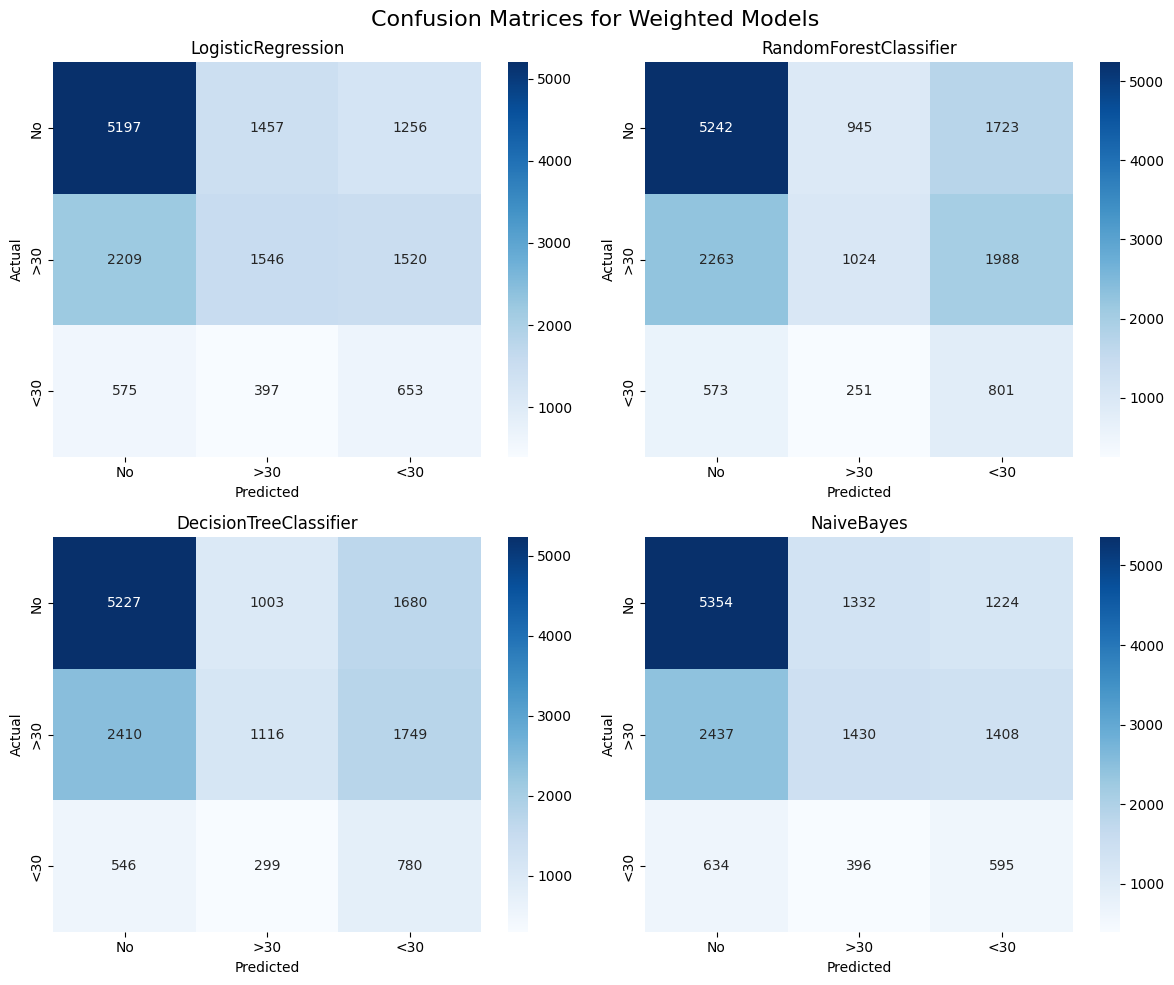

In [36]:
# Compute confusion matrices of weighted predictions
cm_weighted = compute_confusion_matrices(weighted_predictions, label_order)

# Plot confusion matrices of weighted models
plot_confusion_matrices(cm_weighted, class_labels, fig_title="Confusion Matrices for Weighted Models")

**Analysis on Confusion Matrices of Weighted Models**

* Here, we plotted the confusion matrices for the same models after applying class weighting to handle class imbalance. All models are still predicting patient readmission classes: No, >30 days, or <30 days. This helps us see how weighting changes the distribution of predictions across classes.

* **Logistic Regression**

    * Performs reasonably on `No` with 5197 correctly predicted, but still misclassifies 1457 as `>30` and 1256 as `<30`.
    * `>30` is split across all classes, with only 1546 correct out of 5275. 2209 were predicted as `No` and 1520 as `<30`.
    * `Predicts <30` much better than baseline, with 653 correct. Misclassifies 575 as `No` and 397 as `>30`.

* **Random Forest**

    * Predicts `No` fairly well with 5449 correct, better than the others. Still confuses 1753 with `<30`.
    * `>30` class is still mixed. Only 866 were correct, while 2100 were predicted as `<30`.
    * Shows stronger results on `<30` with 813 correct. Fewer misclassifications into `>30` (212) than Logistic.

* **Decision Tree**

    * Predicts `No` correctly for 5227 cases. Misclassifies more into `<30` (1680) compared to others.
    * `>30` is better captured with 1116 correct predictions. Still, 2410 go to `No` and 1749 to `<30`.
    * Predicts `653` `<30` cases correctly, slightly less than Random Forest. Misclassifications are more balanced.

* **Naive Bayes**

    * Predicts `No` correctly for 5354, fairly solid. Misclassifies 1332 as `>30` and 1224 as `<30`.
    * `>30` is captured better than baseline: 1430 correct, with 2437 to `No` and 1408 to `<30`.
    * Slight drop in `<30` predictions with 595 correct cases. Slightly worse than others, with 634 misclassified as `No`.


* Overall, weighting improved the models' ability to detect `<30` cases, especially in **Random Forest** and **Logistic Regression**, but misclassification between `>30` and `<30` increased, showing a trade-off between sensitivity and precision.

In [37]:
# Compute classification reports for weighted predictions
cr_weighted = compute_classification_reports(weighted_predictions)

# Loop through each classification report and print
for cr_df in cr_weighted:
    model = cr_df["Model"].iloc[0]
    print(f"Classification Report for {model} (weighted):")
    print(cr_df.drop(columns=["Model"]).set_index("index"))
    print()

Classification Report for LogisticRegression (weighted):
              precision    recall  f1-score       support
index                                                    
0              0.651172  0.657016  0.654081   7910.000000
1              0.454706  0.293081  0.356427   5275.000000
2              0.190435  0.401846  0.258409   1625.000000
accuracy       0.499392  0.499392  0.499392      0.499392
macro avg      0.432104  0.450648  0.422972  14810.000000
weighted avg   0.530641  0.499392  0.504649  14810.000000

Classification Report for RandomForestClassifier (weighted):
              precision    recall  f1-score       support
index                                                    
0              0.648923  0.662705  0.655742   7910.000000
1              0.461261  0.194123  0.273249   5275.000000
2              0.177527  0.492923  0.261040   1625.000000
accuracy       0.477178  0.477178  0.477178      0.477178
macro avg      0.429237  0.449917  0.396677  14810.000000
weighted av

In [38]:
# Define which metrics and classes to compare
metrics_to_compare = [
    ("accuracy", "Accuracy"),
    ("macro avg", "Macro F1"),
    ("weighted avg", "Weighted F1"),
    ("0", "Recall (Class 0)"),
    ("1", "Recall (Class 1)"),
    ("2", "Recall (Class 2)"),
]

for base_df, weighted_df in zip(cr_baseline, cr_weighted):
    model_name = base_df["Model"].iloc[0]
    print(f"\n{model_name}")
    summary_rows = []
    for idx, label in metrics_to_compare:
        # Get baseline and weighted values
        base_row = base_df[base_df["index"] == idx]
        weighted_row = weighted_df[weighted_df["index"] == idx]
        if base_row.empty or weighted_row.empty:
            continue
        # For accuracy, use 'precision' column; for others, use 'f1-score' or 'recall'
        if label == "Accuracy":
            base_val = base_row["precision"].values[0]
            weighted_val = weighted_row["precision"].values[0]
        elif "Recall" in label:
            base_val = base_row["recall"].values[0]
            weighted_val = weighted_row["recall"].values[0]
        else:
            base_val = base_row["f1-score"].values[0]
            weighted_val = weighted_row["f1-score"].values[0]
        summary_rows.append({
            "Metric": label,
            "Baseline": f"{base_val:.3f}",
            "Weighted": f"{weighted_val:.3f}",
            "Change": f"{(weighted_val-base_val):+.3f}"
        })
    # Create DataFrame for pretty printing
    summary_df = pd.DataFrame(summary_rows)
    print(summary_df.to_string(index=False))


LogisticRegression
          Metric Baseline Weighted Change
        Accuracy    0.579    0.499 -0.080
        Macro F1    0.369    0.423 +0.054
     Weighted F1    0.515    0.505 -0.010
Recall (Class 0)    0.892    0.657 -0.235
Recall (Class 1)    0.284    0.293 +0.009
Recall (Class 2)    0.014    0.402 +0.388

RandomForestClassifier
          Metric Baseline Weighted Change
        Accuracy    0.574    0.477 -0.097
        Macro F1    0.351    0.397 +0.046
     Weighted F1    0.501    0.476 -0.025
Recall (Class 0)    0.906    0.663 -0.244
Recall (Class 1)    0.253    0.194 -0.059
Recall (Class 2)    0.000    0.493 +0.493

DecisionTreeClassifier
          Metric Baseline Weighted Change
        Accuracy    0.578    0.481 -0.097
        Macro F1    0.382    0.402 +0.021
     Weighted F1    0.529    0.480 -0.049
Recall (Class 0)    0.835    0.661 -0.174
Recall (Class 1)    0.369    0.212 -0.158
Recall (Class 2)    0.009    0.480 +0.471

NaiveBayes
          Metric Baseline Weighted Cha

**Analysis on Model Performance Changes (Highlights)**

* Here, we highlight the key shifts in model performance after we applied class weighting to address dataset imbalance.

* **Logistic Regression:**
    * We significantly improved detection for the `<30` class (+0.388 Recall change), which was almost ignored before.
    * This came with an expected decrease in overall accuracy (-0.080) and a notable drop in majority `No` class Recall (-0.235).
    * Our Macro F1 score improved (+0.054), indicating better average balance across classes.

* **RandomForestClassifier:**
    * We achieved an outstanding improvement for the `<30` class (+0.492 Recall change), effectively enabling its detection from zero.
    * This model had the largest accuracy drop (-0.098) among all.
    * Our Recall for the `>30` class decreased (-0.111), showing it remains a challenge for this model.

* **DecisionTreeClassifier:**
    * We saw excellent improvement in `<30` detection (+0.476 Recall change), similar to RandomForest.
    * We also experienced a significant accuracy decrease (-0.098).
    * Our Recall for the `>30` class notably decreased as well (-0.146), indicating a weakness.

* **NaiveBayes:**
    * We observed a good improvement for `<30` detection (+0.225 Recall change), though less substantial than the other models.
    * This model had the smallest accuracy decrease (-0.060), making it relatively stable.
    * Uniquely, our Macro F1 slightly decreased (-0.006), suggesting less overall balance improvement compared to others.

**Overall Summary:**

Overall, we successfully used class weighting to improve detecting minority classes. Specifically, the `<30` class showed significant recall gains across all models. While the `>30` class saw mixed or even decreased recall, the primary goal of improving `<30>` detection was met. We observed an expected drop in overall accuracy and majority class recall. However, for most models, the improved Macro F1 scores indicate a more balanced performance for our imbalanced datasets.

In [39]:
# Compare model performance
summary_weighted = summarize_classification_reports(cr_weighted)
print("Comparison of Weighted Model Performance")
display(summary_weighted)

Comparison of Weighted Model Performance


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall,Weighted Precision,Weighted Recall
0,LogisticRegression,0.499392,0.422972,0.504649,0.432104,0.450648,0.530641,0.499392
3,NaiveBayes,0.498244,0.413309,0.497821,0.424230,0.438036,0.520929,0.498244
2,DecisionTreeClassifier,0.480959,0.402377,0.479629,0.428540,0.450791,0.525886,0.480959
1,RandomForestClassifier,0.477178,0.396677,0.476198,0.429237,0.449917,0.530359,0.477178


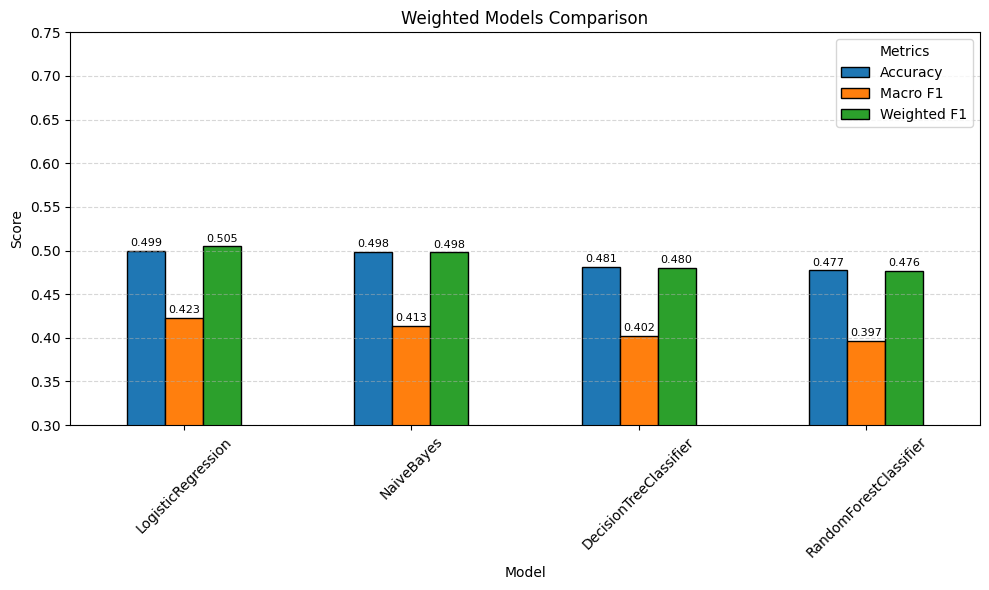

In [40]:
# Plot using baseline summary
plot_model_metrics(summary_df=summary_weighted, fig_title="Weighted Models Comparison")

**Analysis on Model Performance Changes (Highlights)**

Here, drawing insights directly from our "Baseline Models Comparison" and "Weighted Models Comparison" charts, we highlight the most obvious shifts in model performance after we applied class weighting. We'll focus on how the blue (Accuracy), orange (Macro F1), and green (Weighted F1) bars changed for each model.

* **Logistic Regression:**
    * Obvious Shift: The blue bar for Accuracy clearly dropped (-0.080), indicating an expected trade-off. Our orange bar for Macro F1 visibly increased (+0.054), showing better average balance across classes. The green bar for Weighted F1 showed a slight decrease (-0.010).

* **NaiveBayes:**
    * Obvious Shift: The blue bar for Accuracy dropped (-0.061). However, its orange bar for Macro F1 slightly decreased (-0.007), making it an outlier in terms of balanced improvement, and its green bar for Weighted F1 also decreased (-0.029).

* **DecisionTreeClassifier:**
    * Obvious Shift: The blue bar for Accuracy significantly decreased (-0.098). The orange bar for Macro F1 clearly improved (+0.025), indicating a positive shift towards balanced performance, though the green bar for Weighted F1 saw a notable decrease (-0.047).

* **RandomForestClassifier:**
    * Obvious Shift: This model experienced the largest Accuracy drop (-0.098) in its blue bar. Despite this, the orange bar for Macro F1 showed a good improvement (+0.034), while the green bar for Weighted F1 also decreased (-0.037).

**Overall Summary:**

Overall, class weighting notably shifted performance. We saw a clear drop in Accuracy (blue bars) for all models. Importantly, Macro F1 (orange bars) showed a clear positive shift for most, indicating more balanced performance and improved detection for the minority `<30` class.

### Stratified Split

In [66]:
# 1. Convert Spark DF to Pandas
df_pd = final_df.toPandas()

# 2. Fix bool columns to int (0/1)
bool_cols = df_pd.select_dtypes(include='bool').columns
df_pd[bool_cols] = df_pd[bool_cols].astype(int)

# 3. Stratified split
from sklearn.model_selection import train_test_split
train_pd, test_pd = train_test_split(
    df_pd,
    test_size=0.2,
    stratify=df_pd["readmitted_label"],
    random_state=42
)

# 4. Convert back to Spark DataFrame
train_stratified = spark.createDataFrame(train_pd)
test_stratefied = spark.createDataFrame(test_pd)

In [78]:
from pyspark.sql.types import IntegerType

# Remove rows with null label (shouldn't happen, but safe)
train_stratified = train_stratified.filter(col("readmitted_label").isNotNull())

# Cast to IntegerType for Spark compatibility
train_stratified = train_stratified.withColumn("readmitted_label", col("readmitted_label").cast(IntegerType()))
test_stratefied = test_stratefied.withColumn("readmitted_label", col("readmitted_label").cast(IntegerType()))

In [79]:
# Repartition to avoid execution issues
train_stratified = train_stratified.repartition(8)
train_stratified = train_stratified.repartition(8)

In [80]:
train_stratified.printSchema()

root
 |-- admission_type_id: long (nullable = true)
 |-- discharge_disposition_id: long (nullable = true)
 |-- admission_source_id: long (nullable = true)
 |-- time_in_hospital: long (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- age_num: long (nullable = true)
 |-- race_AfricanAmerican: long (nullable = true)
 |-- race_Asian: long (nullable = true)
 |-- race_Caucasian: long (nullable = true)
 |-- race_Hispanic: long (nullable = true)
 |-- race_Other: long (nullable = true)
 |-- race_Unknown: long (nullable = true)
 |-- gender_Female: long (nullable = true)
 |-- gender_Male: long (nullable = true)
 |-- gender_Unknown/Invalid: long (nullable = true)
 |-- age_[20-30): long (nullable = true)
 |--

In [84]:
print("Type:", type(train_stratified))
print("Is DataFrame:", hasattr(train_stratified, "show"))

Type: <class 'pyspark.sql.dataframe.DataFrame'>
Is DataFrame: True


In [90]:
import sys
print(sys.executable)

c:\Users\Home\AppData\Local\Programs\Python\Python312\python.exe


In [85]:
print("Row count:", train_stratified.count())

Py4JJavaError: An error occurred while calling o27585.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3912.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3912.0 (TID 28664) (DESKTOP-FVAIBS9 executor driver): java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:425)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:445)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:831)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:425)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:445)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:831)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)


In [82]:
train_stratified.groupBy("readmitted_label").count().show()

Py4JJavaError: An error occurred while calling o27600.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 3910.0 failed 1 times, most recent failure: Lost task 8.0 in stage 3910.0 (TID 28648) (DESKTOP-FVAIBS9 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.12, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:513)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.12, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:513)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [81]:
label_counts = train_stratified.groupBy("readmitted_label").count().toPandas()
total = label_counts["count"].sum()
class_weights = {row[target_col]: total / row["count"] for _, row in label_counts.iterrows()}

# Get 
train_st_weighted = train_stratified.withColumn(
    "weight",
    when(col("readmitted_label") == 0, lit(class_weights[0]))
    .when(col("readmitted_label") == 1, lit(class_weights[1]))
    .otherwise(lit(class_weights[2]))
)

Py4JJavaError: An error occurred while calling o27591.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 3909.0 failed 1 times, most recent failure: Lost task 8.0 in stage 3909.0 (TID 28636) (DESKTOP-FVAIBS9 executor driver): java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:425)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:445)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:831)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:425)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:445)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:831)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)


## Hyperparameters Tuning

Use cross-validation and grid search to optimize model parameters.


In [64]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define new estimator objects for tuning
lr_tune = LogisticRegression(featuresCol="features_vector", labelCol=target_col)
rf_tune = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col)
dt_tune = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col)
nb_tune = NaiveBayes(featuresCol="features_vector", labelCol=target_col)

# Define models and their parameter grids
tuning_configs = {
    "LogisticRegression": {
        "pipeline": Pipeline(stages=[assembler, lr_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(lr_tune.regParam, [0.01, 0.1, 1.0])
            .addGrid(lr_tune.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
    },
    "RandomForestClassifier": {
        "pipeline": Pipeline(stages=[assembler, rf_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(rf_tune.numTrees, [20, 50])
            .addGrid(rf_tune.maxDepth, [5, 10])
            .build()
    },
    "DecisionTreeClassifier": {
        "pipeline": Pipeline(stages=[assembler, dt_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(dt_tune.maxDepth, [5, 10, 15])
            .build()
    },
    "NaiveBayes": {
        "pipeline": Pipeline(stages=[assembler, nb_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(nb_tune.smoothing, [0.5, 1.0, 2.0])
            .build()
    }
}

In [65]:
# Initialize tuned models dict
tuned_models = {}

# Loop thorugh each tuning configs
for model_name, config in tuning_configs.items():
    print("Tuning", model_name)

    # Create a CrossValidator for the current model config
    crossval = CrossValidator(

        # Set the current pipeline to be evaluated
        estimator=config["pipeline"],

        # Define the grid of hyperparameters to search during cross-validation
        estimatorParamMaps=config["paramGrid"],

        # Uses F1 score as evaluation metric with 3-fold CV
        evaluator=MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1"),
        numFolds=3,

        # Use 2 CPU cores in parallel
        parallelism=2
    )

    cv_model = crossval.fit(train_stratified)
    tuned_models[model_name] = cv_model.bestModel
    print(f"Best {model_name} model selected.")

Tuning LogisticRegression


KeyboardInterrupt: 

In [45]:
# Print best parameters for each model
for name, model in tuned_models.items():
    print(f"Best params for {name}:")
    print(model.stages[-1].extractParamMap())

Best params for LogisticRegression:
{Param(parent='LogisticRegression_663337b96628', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_663337b96628', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_663337b96628', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_663337b96628', name='featuresCol', doc='features column name.'): 'features_vector', Param(parent='LogisticRegression_663337b96628', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_663337b96628', name='labelCol', doc='label column name.'): 'readmitted_label', Param(parent='LogisticRegression_663337b96628', name='ma

In [46]:
# Use evalute_models function again on tuned_models
print("Evaluate Tuned Models on Test Set")
tuned_predictions, tuned_results = evaluate_models(
    tuned_models,
    test_data,
    acc_evaluator,
    f1_evaluator
)

Evaluate Tuned Models on Test Set
LogisticRegression: Accuracy=0.50, F1=0.50

RandomForestClassifier: Accuracy=0.50, F1=0.51

DecisionTreeClassifier: Accuracy=0.48, F1=0.48

NaiveBayes: Accuracy=0.50, F1=0.50



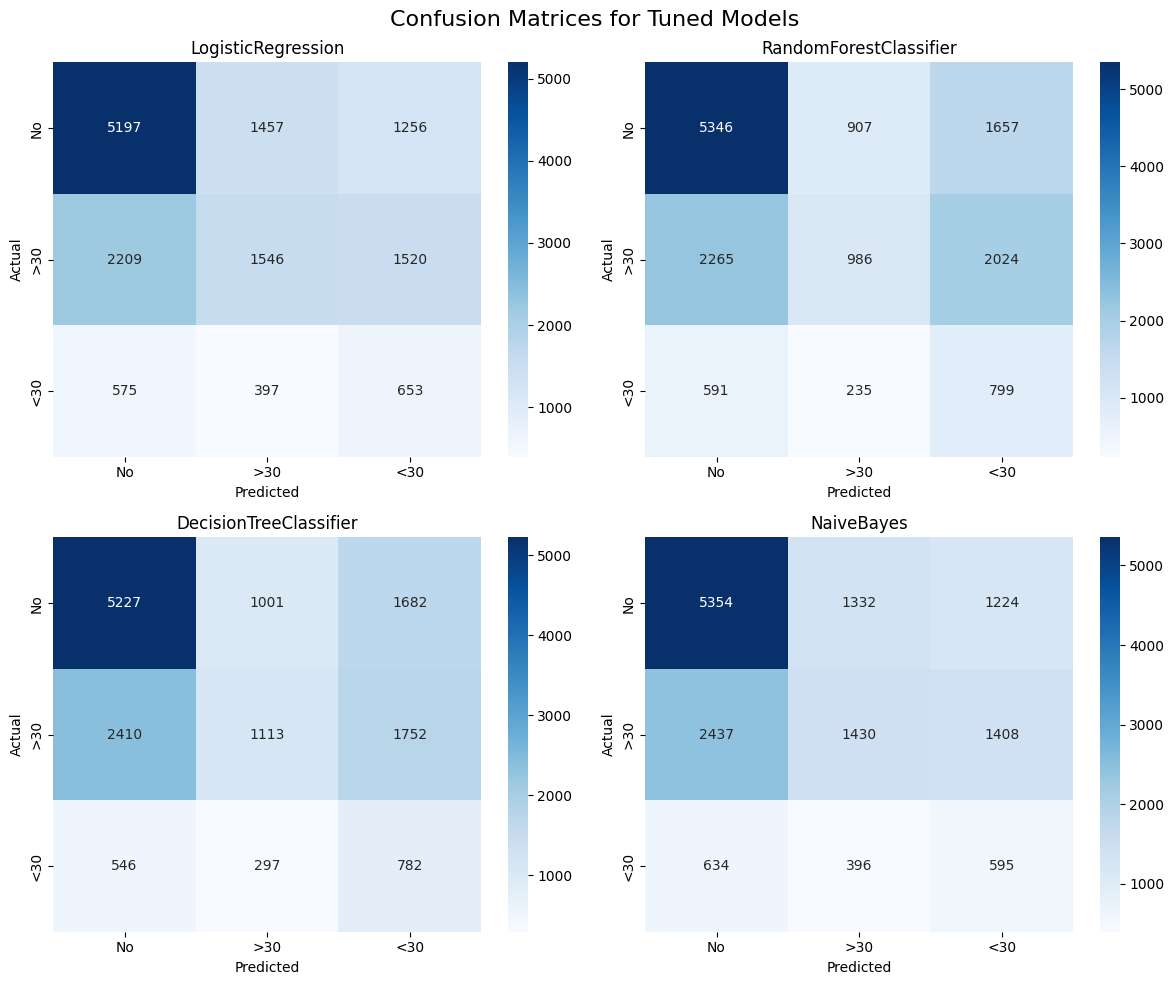

In [ ]:
# Compute confusion matrices of tunred models
cm_tuned = compute_confusion_matrices(tuned_predictions, label_order)

# Plot confusion matrices of weighted models
plot_confusion_matrices(cm_tuned, class_labels, fig_title="Confusion Matrices for Tuned Models")

## Feature Importance Visualization

Visualize which features had the strongest influence on the model’s decisions.


### Save PySpark Model Pipeline